In [1]:
#!/usr/bin/env python
# coding: utf-8
#
# Author: Kazuto Nakashima
# URL:    https://kazuto1011.github.io
# Date:   07 January 2019

from __future__ import absolute_import, division, print_function

import click
import cv2
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from omegaconf import OmegaConf

from libs.models import *
from libs.utils import DenseCRF


def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device


def get_classtable(CONFIG):
    with open(CONFIG.DATASET.LABELS) as f:
        classes = {}
        for label in f:
            label = label.rstrip().split("\t")
            classes[int(label[0])] = label[1].split(",")[0]
    return classes


def setup_postprocessor(CONFIG):
    # CRF post-processor
    postprocessor = DenseCRF(
        iter_max=CONFIG.CRF.ITER_MAX,
        pos_xy_std=CONFIG.CRF.POS_XY_STD,
        pos_w=CONFIG.CRF.POS_W,
        bi_xy_std=CONFIG.CRF.BI_XY_STD,
        bi_rgb_std=CONFIG.CRF.BI_RGB_STD,
        bi_w=CONFIG.CRF.BI_W,
    )
    return postprocessor


def preprocessing(image, device, CONFIG):
    # Resize
    scale = CONFIG.IMAGE.SIZE.TEST / max(image.shape[:2])
    image = cv2.resize(image, dsize=None, fx=scale, fy=scale)
    raw_image = image.astype(np.uint8)

    # Subtract mean values
    image = image.astype(np.float32)
    image -= np.array(
        [
            float(CONFIG.IMAGE.MEAN.B),
            float(CONFIG.IMAGE.MEAN.G),
            float(CONFIG.IMAGE.MEAN.R),
        ]
    )

    # Convert to torch.Tensor and add "batch" axis
    image = torch.from_numpy(image.transpose(2, 0, 1)).float().unsqueeze(0)
    image = image.to(device)

    return image, raw_image


def inference(model, image, raw_image=None, postprocessor=None):
    _, _, H, W = image.shape

    # Image -> Probability map
    logits = model(image)
    logits = F.interpolate(logits, size=(H, W), mode="bilinear", align_corners=False)
    probs = F.softmax(logits, dim=1)[0]
    probs = probs.cpu().numpy()

    # Refine the prob map with CRF
    if postprocessor and raw_image is not None:
        probs = postprocessor(raw_image, probs)

    labelmap = np.argmax(probs, axis=0)

    return labelmap

In [17]:
def single(config_path, model_path, image_path, cuda, crf):
    """
    Inference from a single image
    """

    # Setup
    CONFIG = OmegaConf.load(config_path)
    device = get_device(cuda)
    torch.set_grad_enabled(False)

    classes = get_classtable(CONFIG)
    postprocessor = setup_postprocessor(CONFIG) if crf else None

    model = eval(CONFIG.MODEL.NAME)(n_classes=CONFIG.DATASET.N_CLASSES)
    state_dict = torch.load(model_path, map_location=lambda storage, loc: storage)
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)
    print("Model:", CONFIG.MODEL.NAME)

    # Inference
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image, raw_image = preprocessing(image, device, CONFIG)
    labelmap = inference(model, image, raw_image, postprocessor)
    labels = np.unique(labelmap)

    # Show result for each class
    rows = np.floor(np.sqrt(len(labels) + 1))
    cols = np.ceil((len(labels) + 1) / rows)

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(rows, cols, 1)
    ax.set_title("Input image")
    ax.imshow(raw_image[:, :, ::-1])
    ax.axis("off")

    for i, label in enumerate(labels):
        mask = labelmap == label
        ax = plt.subplot(rows, cols, i + 2)
        ax.set_title(classes[label])
        ax.imshow(raw_image[..., ::-1])
        ax.imshow(mask.astype(np.float32), alpha=0.5)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    return labelmap

Device: TITAN RTX
Model: DeepLabV2_ResNet101_MSC
/home/alessandro/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/home/alessandro/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/home/alessandro/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Passing no

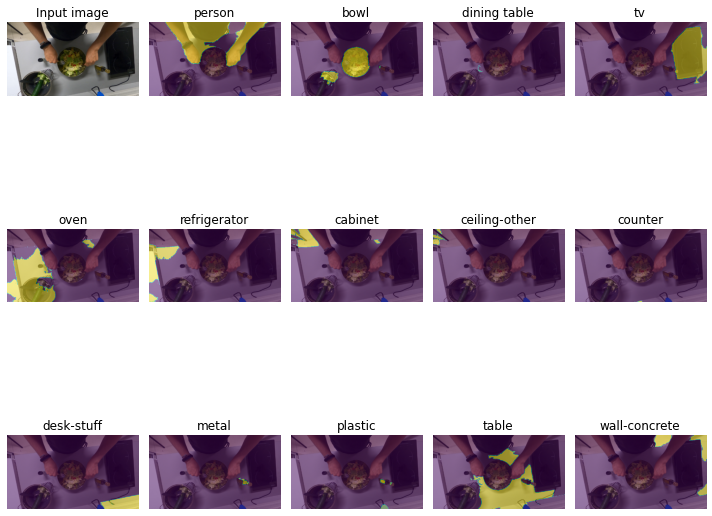

In [327]:
config_path = 'configs/cocostuff164k.yaml'
model_path = 'models/deeplabv2_resnet101_msc-cocostuff164k-100000.pth'
image_sel = 'ego'
image_path = '/media/data/alessandro/smart_kitchen/frames_coco/' + image_sel + '.png'

labelmap = single(config_path, model_path, image_path, True, True)

In [328]:
CONFIG = OmegaConf.load(config_path)

classes = get_classtable(CONFIG)

labels = np.unique(labelmap)

print(classes[labels[0]])

person


Device: TITAN RTX
/home/alessandro/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # This is added back by InteractiveShellApp.init_path()
/home/alessandro/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


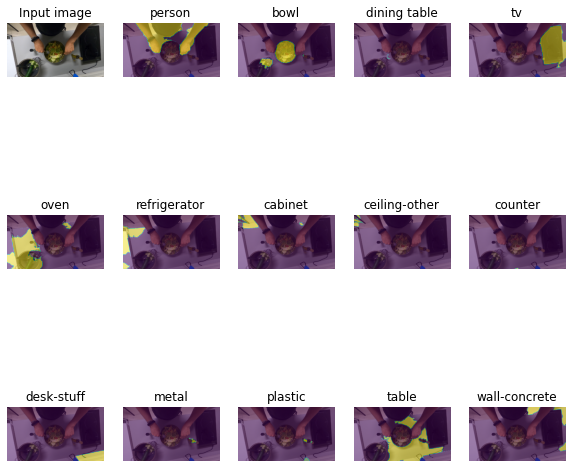

In [329]:
device = get_device(True)

image = cv2.imread(image_path, cv2.IMREAD_COLOR)
image, raw_image = preprocessing(image, device, CONFIG)

# Show result for each class
rows = np.floor(np.sqrt(len(labels) + 1))
cols = np.ceil((len(labels) + 1) / rows)

plt.figure(figsize=(10, 10))
ax = plt.subplot(rows, cols, 1)
ax.set_title("Input image")
ax.imshow(raw_image[:, :, ::-1])
ax.axis("off")

for i, label in enumerate(labels):
    mask = labelmap == label
    ax = plt.subplot(rows, cols, i + 2)
    ax.set_title(classes[label])
    ax.imshow(raw_image[..., ::-1])
    ax.imshow(mask.astype(np.float32), alpha=0.5)
    ax.axis("off")

In [330]:
#mask_person = []
#label_person = []
mask_table = np.zeros_like(labelmap) #0
mask_person = np.zeros_like(labelmap)
mask_broccoli = np.zeros_like(labelmap)
mask_bowl = np.zeros_like(labelmap)
mask_floor = np.zeros_like(labelmap)
mask_wall = np.zeros_like(labelmap)
mask_shelf = np.zeros_like(labelmap)
for i, label in enumerate(labels):
    if 'person' in classes[label]:
        print('person')
        mask = labelmap == label 
        #mask_list.append(mask)
        #label_list.append(label)
        mask_person += mask
        label_person = label
    if 'broccoli' in classes[label]:
        print('broccoli')
        mask = labelmap == label 
        #mask_list.append(mask)
        #label_list.append(label)
        mask_broccoli += mask
        label_broccoli = label
    if 'bowl' in classes[label]:
        print('bowl')
        mask = labelmap == label 
        #mask_list.append(mask)
        #label_list.append(label)
        mask_bowl += mask
        label_bowl = label
    if 'floor' in classes[label]:
        print('floor')
        mask = labelmap == label 
        #mask_list.append(mask)
        #label_list.append(label)
        mask_floor += mask
        label_floor = label
    if 'wall' in classes[label]:
        print('wall')
        mask = labelmap == label 
        #mask_list.append(mask)
        #label_list.append(label)
        mask_wall += mask
        label_wall = label
    if ('table' in classes[label]) or ('desk' in classes[label]):
        print('table')
        mask = labelmap == label 
        #mask_list.append(mask)
        #label_list.append(label)
        mask_table += mask
        label_table = label
    if 'shelf' in classes[label]:
        print('shelf')
        mask = labelmap == label 
        #mask_list.append(mask)
        #label_list.append(label)
        mask_shelf += mask
        label_shelf = label

#flag_table = False
#for i, label in enumerate(labels):
 #   if 'table' in classes[label]:
 #       mask = labelmap == label 
 #       #mask_list.append(mask)
        #label_list.append(label)
 #       if flag_table:
 #           mask_table += mask
 #       else:
  #          mask_table = mask
  #          label_table = label
  #      flag_table = True


mask1 = np.zeros_like(labelmap) +60
mask_table = mask_table*85
mask_person = mask_person*30
mask_broccoli = mask_broccoli*20
mask_bowl = mask_bowl*1
mask_floor = mask_floor*10
mask_wall = mask_wall*75

mask_shelf = mask_shelf*51

mask1 = mask_table + mask_person + mask_broccoli + mask_bowl + mask_floor + mask_wall + mask_shelf
mask1[mask1 == 0] = 60

person
bowl
table
table
table
wall


In [331]:
print(mask1 )

[[60 60 60 ... 75 75 75]
 [60 60 60 ... 75 75 75]
 [60 60 60 ... 75 75 75]
 ...
 [60 60 60 ... 85 85 85]
 [60 60 60 ... 85 85 85]
 [60 60 60 ... 85 85 85]]


/home/alessandro/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


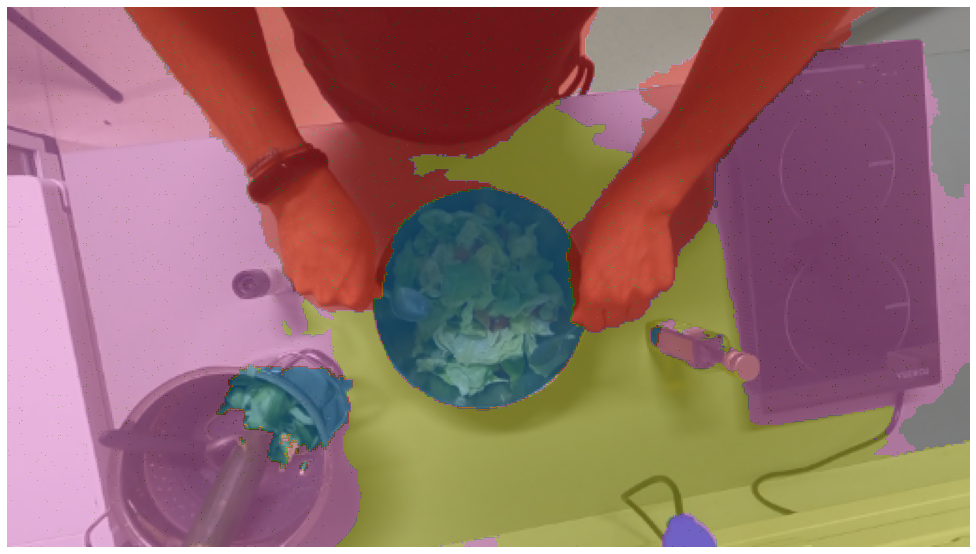

In [340]:
plt.figure(figsize=(100, 100))
ax = plt.subplot(rows, cols, 1)
#ax.set_title("Input image")
ax.imshow(raw_image[:, :, ::-1])
ax.axis("off")

#for i, label in enumerate(labels):
 #   mask = labelmap == label
 #   ax = plt.subplot(rows, cols, i + 2)
 #   ax.set_title(classes[label])
ax.imshow(raw_image[..., ::-1])
ax.imshow(mask1.astype(np.float32), cmap = 'tab10', alpha=0.5, vmin=0, vmax=100)  #labelmap
#ax.imshow(mask_person.astype(np.float32), alpha=0.5)
#ax.imshow(mask_broccoli.astype(np.float32),  alpha=0.5)
#ax.imshow(mask_bowl.astype(np.float32),  alpha=0.5)

ax.axis("off")
plt.savefig(image_sel +'.svg', format='svg')

In [338]:
plt.savefig?

Signature: plt.savefig(*args, **kwargs)
Docstring:
Save the current figure.

Call signature::

  savefig(fname, dpi=None, facecolor='w', edgecolor='w',
          orientation='portrait', papertype=None, format=None,
          transparent=False, bbox_inches=None, pad_inches=0.1,
          frameon=None, metadata=None)

The available output formats depend on the backend being used.

Parameters
----------
fname : str or path-like or file-like
    A path, or a Python file-like object, or
    possibly some backend-dependent object such as
    `matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is set, it determines the output format, and the file
    is saved as *fname*.  Note that *fname* is used verbatim, and there
    is no attempt to make the extension, if any, of *fname* match
    *format*, and no extension is appended.

    If *format* is not set, then the format is inferred from the
    extension of *fname*, if there is one.  If *format* is not
    set and *fname* has no exten

/home/alessandro/anaconda3/envs/deeplab-pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  


(-0.5, 285.5, 512.5, -0.5)

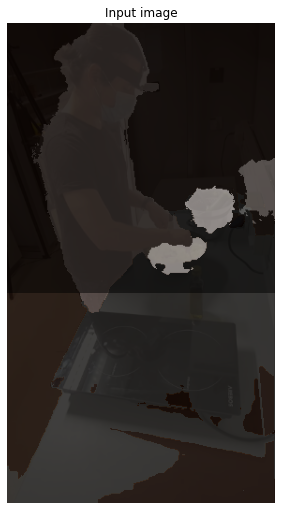

In [167]:
plt.figure(figsize=(30, 30))
ax = plt.subplot(rows, cols, 1)
ax.set_title("Input image")
ax.imshow(raw_image[:, :, ::-1])
ax.axis("off")

#for i, label in enumerate(labels):
 #   mask = labelmap == label
 #   ax = plt.subplot(rows, cols, i + 2)
 #   ax.set_title(classes[label])
ax.imshow(raw_image[..., ::-1])
ax.imshow(mask_table.astype(np.float32), cm.get_cmap('Oranges_r', 1000), alpha=0.5)  #labelmap
ax.imshow(mask_person.astype(np.float32), cmap='gray', alpha=0.5)
ax.imshow(mask_broccoli.astype(np.float32), cmap='gray', alpha=0.5)
ax.imshow(mask_bowl.astype(np.float32), cmap='gray', alpha=0.5)

ax.axis("off")